In [8]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import PIL
import PIL.Image
import pandas as pd
import pathlib, datetime

In [2]:
!python -m wget https://www.dropbox.com/s/0htmeoie69q650p/miml_dataset.zip


Saved under miml_dataset.zip


In [6]:
from zipfile import ZipFile
zf = ZipFile('./miml_dataset.zip', 'r')
zf.extractall('./data/')
zf.close()

In [9]:
df = pd.read_csv("./miml_dataset/miml_labels_1.csv")
df.head()

,Filenames,desert,mountains,sea,sunset,trees
0,1.jpg,1,0,0,0,0
1,2.jpg,1,0,0,0,0
2,3.jpg,1,0,0,0,0
3,4.jpg,1,1,0,0,0
4,5.jpg,1,0,0,0,0


In [10]:
LABELS = ["desert", "mountains", "sea", "sunset", "trees"]

In [13]:
data_dir = pathlib.Path("miml_dataset")
filenames = list(data_dir.glob('images/*.jpg'))
fnames = []
for fname in filenames:
  fnames.append(str(fname))

In [14]:
ds_size= len(fnames)
print("Number of images in folders: ", ds_size)

number_of_selected_samples=2000
filelist_ds = tf.data.Dataset.from_tensor_slices(fnames[:number_of_selected_samples])

ds_size= filelist_ds.cardinality().numpy()
print("Number of selected samples for dataset: ", ds_size)

Number of images in folders:  2000
Number of selected samples for dataset:  2000


In [15]:
def get_label(file_path):
  parts = tf.strings.split(file_path, '/')
  file_name = parts[-1]
  labels = df[df["Filenames"] == file_name][LABELS].to_numpy().squeeze()
  return tf.convert_to_tensor(labels)

In [16]:
IMG_WIDTH, IMG_HEIGHT = 64 , 64
def decode_img(img):
  #color images
  img = tf.image.decode_jpeg(img, channels=3) 
  #convert unit8 tensor to floats in the [0,1]range
  img = tf.image.convert_image_dtype(img, tf.float32) 
  #resize 
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT]) 

In [17]:
def combine_images_labels(file_path: tf.Tensor):
  label = get_label(file_path)
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [18]:
train_ratio = 0.80
ds_train = filelist_ds.take(ds_size * train_ratio)
ds_test = filelist_ds.skip(ds_size * train_ratio)

In [19]:
BATCH_SIZE = 64

In [20]:
ds_train = ds_train.map(lambda x: tf.py_function(func = combine_images_labels,
          inp =[x], Tout = (tf.float32,tf.int64)),
          num_parallel_calls = tf.data.AUTOTUNE,
          deterministic = False)

In [21]:
ds_test = ds_test.map(lambda x: tf.py_function(func = combine_images_labels,
          inp = [x], Tout = (tf.float32,tf.int64)),
          num_parallel_calls = tf.data.AUTOTUNE,
          deterministic = False)

In [22]:
def covert_onehot_string_labels(label_string,label_onehot):
  labels = []
  for i, label in  enumerate(label_string):
     if label_onehot[i]:
       labels.append(label)
  if len(labels) == 0:
    labels.append("NONE")
  return labels

9 samples from the dataset


IndexError: index 0 is out of bounds for axis 0 with size 0

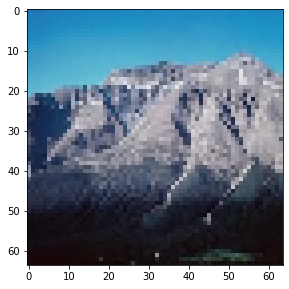

In [23]:
def show_samples(dataset):
  fig = plt.figure(figsize = (16, 16))
  columns = 3
  rows = 3
  print(columns*rows,"samples from the dataset")
  i = 1
  for a, b in dataset.take(columns * rows): 
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(a))
    plt.title("image shape:"+ str(a.shape)+" ("+str(b.numpy()) +") "+ 
              str(covert_onehot_string_labels(LABELS,b.numpy())))
    i = i+1
  plt.show()
show_samples(ds_test)

In [24]:
#buffer_size = ds_train_resize_scale.cardinality().numpy()/10
#ds_resize_scale_batched=ds_raw.repeat(3).shuffle(buffer_size=buffer_size).batch(64, )

ds_train_batched = ds_train.batch(BATCH_SIZE).cache().prefetch(tf.data.experimental.AUTOTUNE) 
ds_test_batched = ds_test.batch(BATCH_SIZE).cache().prefetch(tf.data.experimental.AUTOTUNE)

print("Number of batches in train: ", ds_train_batched.cardinality().numpy())
print("Number of batches in test: ", ds_test_batched.cardinality().numpy())

Number of batches in train:  25
Number of batches in test:  7


In [25]:
base_model = keras.applications.VGG16(
    weights = 'imagenet',  # Load weights pre-trained on ImageNet.
    input_shape = (64, 64, 3), # VGG16 expects min 32 x 32
    include_top = False)  # Do not include the ImageNet classifier at the top.
base_model.trainable = False

58892288/58889256 [==============================] - 0s 0us/step


In [26]:
number_of_classes = 5

In [28]:
inputs = keras.Input(shape = (64, 64, 3))
x = base_model(inputs, training = False)
x = keras.layers.GlobalAveragePooling2D()(x)
initializer = tf.keras.initializers.GlorotUniform(seed = 42)

activation = tf.keras.activations.sigmoid #None  # tf.keras.activations.sigmoid or softmax

outputs = keras.layers.Dense(number_of_classes,
                             kernel_initializer=initializer,
                             activation=activation)(x) 
model = keras.Model(inputs, outputs)

In [29]:
model.compile(optimizer = keras.optimizers.Adam(),
              loss = keras.losses.BinaryCrossentropy(), # default from_logits=False
              metrics = [keras.metrics.BinaryAccuracy()])

In [30]:
model.fit(ds_train_batched, validation_data = ds_test_batched, epochs = 100)

Epoch 1/100
25/25 [==============================] - 392s 14s/step - loss: 0.5993 - binary_accuracy: 0.6870 - val_loss: 0.5422 - val_binary_accuracy: 0.7465
Epoch 2/100
25/25 [==============================] - 1s 33ms/step - loss: 0.5189 - binary_accuracy: 0.7620 - val_loss: 0.5134 - val_binary_accuracy: 0.7575
Epoch 3/100
25/25 [==============================] - 1s 29ms/step - loss: 0.4864 - binary_accuracy: 0.7747 - val_loss: 0.4862 - val_binary_accuracy: 0.7675
Epoch 4/100
25/25 [==============================] - 1s 30ms/step - loss: 0.4615 - binary_accuracy: 0.7847 - val_loss: 0.4665 - val_binary_accuracy: 0.7775
Epoch 5/100
25/25 [==============================] - 1s 29ms/step - loss: 0.4418 - binary_accuracy: 0.7919 - val_loss: 0.4514 - val_binary_accuracy: 0.7885
Epoch 6/100
25/25 [==============================] - 1s 29ms/step - loss: 0.4261 - binary_accuracy: 0.8020 - val_loss: 0.4392 - val_binary_accuracy: 0.8005
Epoch 7/100
25/25 [==============================] - 1s 29ms/st

In [31]:
ds = ds_test_batched
print("Test Accuracy: ", model.evaluate(ds)[1])

7/7 [==============================] - 0s 20ms/step - loss: 0.3281 - binary_accuracy: 0.8590
Test Accuracy:  0.8590000867843628


In [34]:
ds = ds_test
predictions = model.predict(ds.batch(batch_size = 10).take(1))
print("A sample output from the last layer (model) ", predictions[0])
y = []
limiar = 0.5
print("10 Sample predictions:")
for (pred, (a, b)) in zip(predictions, ds.take(10)):
  
  pred[pred > limiar] = 1
  pred[pred <= limiar] = 0
  print("predicted: " , pred, str(covert_onehot_string_labels(LABELS, pred)),  
        "Actual Label: ("+str(covert_onehot_string_labels(LABELS,b.numpy())) +")")
  y.append(b.numpy())

A sample output from the last layer (model)  [0.10203172 0.29928726 0.3711271  0.18140112 0.0447447 ]
10 Sample predictions:
predicted:  [0. 0. 0. 0. 0.] ['NONE'] Actual Label: (['sunset'])
predicted:  [0. 0. 0. 0. 0.] ['NONE'] Actual Label: (['desert'])
predicted:  [1. 0. 0. 0. 0.] ['desert'] Actual Label: (['desert'])
predicted:  [0. 0. 0. 0. 0.] ['NONE'] Actual Label: (['mountains', 'trees'])
predicted:  [0. 0. 0. 0. 1.] ['trees'] Actual Label: (['trees'])
predicted:  [0. 0. 1. 0. 0.] ['sea'] Actual Label: (['sea'])
predicted:  [0. 0. 0. 1. 0.] ['sunset'] Actual Label: (['sunset'])
predicted:  [0. 0. 1. 1. 0.] ['sea', 'sunset'] Actual Label: (['sea', 'sunset'])
predicted:  [0. 0. 0. 1. 0.] ['sunset'] Actual Label: (['sunset', 'trees'])
predicted:  [0. 0. 0. 0. 0.] ['NONE'] Actual Label: (['desert'])
